In [1]:
#@title Install
import torch
from torch.utils.data import DataLoader, IterableDataset
from datasets import load_dataset, load_from_disk
from transformers import CLIPModel, CLIPProcessor
from huggingface_hub import login
from torch.utils.data import Dataset

from sae.config import SaeConfig, TrainConfig
from sae.trainer import SaeTrainer  

from PIL import Image

print("done")

done


In [2]:
# @title Pre Process

dataset = load_from_disk(
    "mini-imagenet"
    )
dataset = dataset.shuffle(seed=35)

class CLIPImageDataset(Dataset):
    """
    A map-style dataset that returns a single (image, label) pair
    in the format your model expects.
    """
    def __init__(self, hf_dataset, clip_processor):
        super().__init__()
        self.hf_dataset = hf_dataset   
        self.clip_processor = clip_processor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        # Process the image with the CLIP processor
        proc = self.clip_processor(images=sample["image"], return_tensors="pt")
        # shape [1, 3, 224, 224], so we squeeze out the batch dimension
        pixel_values = proc["pixel_values"].squeeze(0)  # -> [3,224,224]
        label = sample.get("label", -1)
        return {
            "input_ids": pixel_values,
            "labels": label
        }


clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
feature_dataset = CLIPImageDataset(dataset, clip_processor)



0.29092079401016235 0.0014507692540064454
3072 latents out of 3072 were used at least once.
Top 10 most-used latents: [(758, 31822), (1599, 30932), (124, 29632), (219, 29516), (2913, 28822), (292, 28462), (874, 27926), (2828, 27652), (2589, 27466), (901, 27260)]
Bottom 10 least-used latents: [(1745, 1310), (270, 1308), (2976, 1284), (18, 1278), (376, 1240), (254, 1238), (1095, 1204), (2157, 1190), (744, 1088), (2379, 978)]


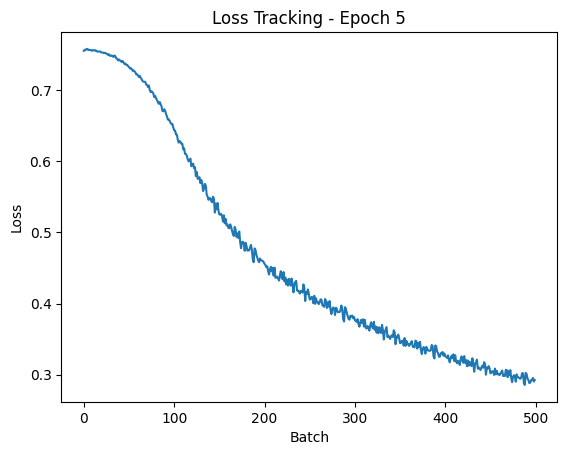

Saving checkpoint


In [3]:
#@title Train
%matplotlib inline

from sae.config import SaeConfig, TrainConfig
from sae.trainer import SaeTrainer
from matplotlib import pyplot as plt


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
clip_model = clip_model.to(device)  
print(clip_model.device)

# for name, _ in clip_model.named_modules():
#     if "vision_model.encoder.layers.9" in name:
#         print("Found:", name)
#    The snippet references the "vision_model.encoder.layers.<X>" submodules.
chosen_hookpoints = ["vision_model.encoder.layers.11"]

sae_cfg = SaeConfig(
    expansion_factor=4,
    k=64,
    skip_connection=False,
    normalize_decoder=False,
    num_latents=3072,
    multi_topk=False,
)
train_cfg = TrainConfig(
    sae=sae_cfg,
    batch_size=500,
    lr=5e-4,      
    hookpoints=chosen_hookpoints,
    layers=[],    #rely on hookpoints directly
    log_to_wandb=False,
    run_name="clip_sae",
    save_every=1000,  
)

trainer = SaeTrainer(
    cfg=train_cfg,
    dataset=feature_dataset,
    model=clip_model,
)
print("CUDaa AVAILABLE: ", torch.cuda.is_available())
track_loss = trainer.fit()